# Simple PySpark ML Examples

## Learning Goals:
- Basic Linear Regression with PySpark
- Simple Logistic Regression for classification
- Essential text processing with Spark
- Basic time series analysis

## Dataset:
- Banking transaction data
- Fields: client_id, amount, merchant info, date
- Simple fraud detection example

In [6]:
# Essential PySpark ML Imports with Detailed Explanations

# Core Spark Components
from pyspark.sql import SparkSession          # Main entry point for Spark SQL functionality
from pyspark.sql.functions import *           # SQL functions for DataFrame operations

# Machine Learning Components
from pyspark.ml.feature import VectorAssembler    # Combines multiple columns into feature vector
from pyspark.ml.regression import LinearRegression # Linear regression algorithm
from pyspark.ml.classification import LogisticRegression # Logistic regression for classification
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator # Model evaluation
from pyspark.ml import Pipeline              # Chains multiple ML stages together

# Data Analysis and Visualization Libraries  
import pandas as pd                           # For small data manipulation and analysis
import matplotlib.pyplot as plt              # Plotting and visualization
import numpy as np                           # Numerical operations and array handling

print("Import Details:")
print("="*60)
print("PySpark SQL:")
print("  • SparkSession: Creates Spark application context")
print("  • sql.functions: SQL operations (col, sum, avg, etc.)")
print("")
print("PySpark ML:")
print("  • VectorAssembler: Combines features into ML-ready format")
print("  • LinearRegression: Predicts continuous values (regression)")  
print("  • LogisticRegression: Predicts categories (classification)")
print("  • Evaluators: Calculate model performance metrics")
print("  • Pipeline: Automates ML workflow (preprocessing + modeling)")
print("")
print("Python Libraries:")
print("  • pandas: Small data analysis (Spark → pandas conversion)")
print("  • matplotlib: Create charts and visualizations")
print("  • numpy: Mathematical operations and arrays")
print("")
print("✓ All imports successful - Ready for distributed ML!")

Import Details:
PySpark SQL:
  • SparkSession: Creates Spark application context
  • sql.functions: SQL operations (col, sum, avg, etc.)

PySpark ML:
  • VectorAssembler: Combines features into ML-ready format
  • LinearRegression: Predicts continuous values (regression)
  • LogisticRegression: Predicts categories (classification)
  • Evaluators: Calculate model performance metrics
  • Pipeline: Automates ML workflow (preprocessing + modeling)

Python Libraries:
  • pandas: Small data analysis (Spark → pandas conversion)
  • matplotlib: Create charts and visualizations
  • numpy: Mathematical operations and arrays

✓ All imports successful - Ready for distributed ML!


In [8]:
# Spark Session Setup with Comprehensive Configuration
print("Initializing Apache Spark session...")

# Create SparkSession with detailed configuration
spark = SparkSession.builder \
    .appName("SimpleBankingML") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

# Configure logging to reduce noise (focus on warnings and errors only)
spark.sparkContext.setLogLevel("WARN")

# Display Spark configuration and cluster information
print("Spark Session Configuration:")
print("="*50)
print(f"✓ Application Name: {spark.sparkContext.appName}")
print(f"✓ Spark Version: {spark.version}")
print(f"✓ Master URL: {spark.sparkContext.master}")
print(f"✓ Default Parallelism: {spark.sparkContext.defaultParallelism}")
print(f"✓ Adaptive Query Execution: Enabled")
print(f"✓ Logging Level: WARN (reduced verbosity)")

# Explain Spark cluster setup
print(f"\nSpark Cluster Information:")
print("="*50)
if "local" in spark.sparkContext.master:
    print("Running in LOCAL mode:")
    print("  • Single machine execution")
    print("  • All cores available for parallel processing")
    print("  • Suitable for development and small datasets")
else:
    print("Running in CLUSTER mode:")
    print("  • Distributed across multiple nodes")
    print("  • Horizontal scalability")
    print("  • Suitable for production and large datasets")

# Performance optimization settings explained
print(f"\nPerformance Optimizations:")
print("="*50)
print("Adaptive Query Execution (AQE):")
print("  • Dynamically optimizes query plans during execution")
print("  • Automatically coalesces small partitions")
print("  • Reduces shuffle overhead and improves performance")
print("")
print("Memory Management:")
print("  • DataFrames cached automatically when beneficial")
print("  • Lazy evaluation - operations optimized before execution")
print("  • Columnar storage format for efficient analytics")

print(f"\n🚀 Spark session ready for distributed machine learning!")

Initializing Apache Spark session...


25/08/12 00:41:51 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.command

Spark Session Configuration:
✓ Application Name: SimpleBankingML
✓ Spark Version: 3.5.3
✓ Master URL: local[*]
✓ Default Parallelism: 8
✓ Adaptive Query Execution: Enabled
✓ Logging Level: WARN (reduced verbosity)

Spark Cluster Information:
Running in LOCAL mode:
  • Single machine execution
  • All cores available for parallel processing
  • Suitable for development and small datasets

Performance Optimizations:
Adaptive Query Execution (AQE):
  • Dynamically optimizes query plans during execution
  • Automatically coalesces small partitions
  • Reduces shuffle overhead and improves performance

Memory Management:
  • DataFrames cached automatically when beneficial
  • Lazy evaluation - operations optimized before execution
  • Columnar storage format for efficient analytics

🚀 Spark session ready for distributed machine learning!


In [ ]:
# Data Loading and Preprocessing with Extensive Comments
print("Starting comprehensive data loading and preprocessing...")

# Step 1: Load CSV data using Spark's distributed file reader
# Spark can read large files across multiple nodes automatically
df = spark.read.csv(
    "../data/transactions_data.csv",    # File path (relative to notebook)
    header=True,                        # First row contains column names
    inferSchema=True                   # Automatically detect data types
)

print(f"Raw data loaded from CSV:")
print(f"  Rows: {df.count():,}")          # Count triggers first Spark action
print(f"  Columns: {len(df.columns)}")    # Number of features
print(f"  Schema inference: Enabled")     # Spark auto-detected types

# Display schema information (data types and null handling)
print(f"\nData Schema Analysis:")
df.printSchema()

# Show sample of raw data to understand structure
print(f"\nRaw Data Sample (first 5 rows):")
df.show(5, truncate=False)  # Don't truncate to see full values

# Step 2: Data Quality Assessment
print(f"\nData Quality Assessment:")
print("="*50)

# Check for null values across all columns
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
print(f"Null value analysis:")
for column in df.columns:
    null_count = null_counts[column]
    null_percentage = (null_count / df.count()) * 100 if df.count() > 0 else 0
    print(f"  {column}: {null_count:,} nulls ({null_percentage:.1f}%)")

# Step 3: Advanced Data Cleaning and Feature Engineering
print(f"\nData Cleaning and Feature Engineering:")
print("="*50)

df_clean = df \
    .withColumn("amount_numeric", 
                regexp_replace(col("amount"), "[\$,]", "").cast("double")) \
    .withColumn("is_online", 
                (col("merchant_city") == "ONLINE").cast("int")) \
    .filter(col("amount_numeric") > 0)  # Remove invalid amounts

print(f"Data cleaning steps applied:")
print(f"1. Amount Processing:")
print(f"   - Original: Text with $ and commas (e.g., '$1,234.56')")
print(f"   - Cleaned: Numeric double (e.g., 1234.56)")
print(f"   - Method: regex_replace() removes '$' and ',' characters")
print(f"   - Conversion: cast('double') converts string to numeric")

print(f"\n2. Channel Classification:")
print(f"   - Feature: is_online (binary: 0=in-person, 1=online)")
print(f"   - Logic: merchant_city == 'ONLINE' → 1, else 0")
print(f"   - Purpose: Distinguish transaction channels for analysis")

print(f"\n3. Data Filtering:")
print(f"   - Remove transactions with amount <= 0")
print(f"   - Ensures valid monetary transactions only")
print(f"   - Prevents division by zero and negative amount issues")

# Step 4: Post-cleaning Data Statistics
print(f"\nPost-Cleaning Data Statistics:")
print("="*50)

# Cache the cleaned DataFrame for better performance
df_clean.cache()  # Stores in memory across cluster nodes
print(f"✓ DataFrame cached for performance optimization")

clean_count = df_clean.count()
print(f"Final dataset size: {clean_count:,} transactions")
print(f"Data reduction: {df.count() - clean_count:,} rows removed ({((df.count() - clean_count)/df.count())*100:.1f}%)")

# Analyze the cleaned amount distribution
amount_stats = df_clean.select("amount_numeric").describe()
print(f"\nTransaction Amount Statistics:")
amount_stats.show()

# Analyze channel distribution
channel_stats = df_clean.groupBy("is_online").agg(
    count("*").alias("transaction_count"),
    avg("amount_numeric").alias("avg_amount")
).withColumn("channel", 
             when(col("is_online") == 1, "Online").otherwise("In-Person"))

print(f"\nTransaction Channel Analysis:")
channel_stats.select("channel", "transaction_count", "avg_amount").show()

# Step 5: Data Validation
print(f"\nData Validation Checks:")
print("="*50)

# Validate amount_numeric column
invalid_amounts = df_clean.filter(col("amount_numeric").isNull() | (col("amount_numeric") <= 0)).count()
print(f"✓ Invalid amounts: {invalid_amounts} (should be 0)")

# Validate is_online column
online_values = df_clean.select("is_online").distinct().collect()
online_vals = [row.is_online for row in online_values]
print(f"✓ Online flag values: {sorted(online_vals)} (should be [0, 1])")

# Check for required columns
required_columns = ["client_id", "amount_numeric", "is_online", "date"]
missing_columns = [col for col in required_columns if col not in df_clean.columns]
if missing_columns:
    print(f"❌ Missing required columns: {missing_columns}")
else:
    print(f"✓ All required columns present: {required_columns}")

print(f"\nData preprocessing completed successfully!")
print(f"Ready for machine learning pipeline...")

<>:43: SyntaxWarning: invalid escape sequence '\$'
<>:43: SyntaxWarning: invalid escape sequence '\$'
/var/folders/z7/qy1l6b2n5ljd7dqzvm5cd2f40000gn/T/ipykernel_36458/614662019.py:43: SyntaxWarning: invalid escape sequence '\$'
  regexp_replace(col("amount"), "[\$,]", "").cast("double")) \


Starting comprehensive data loading and preprocessing...


Raw data loaded from CSV:


  Rows: 13,305,915
  Columns: 12
  Schema inference: Enabled

Data Schema Analysis:
root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: string (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: double (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)


Raw Data Sample (first 5 rows):
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+
|id     |date               |client_id|card_id|amount |use_chip         |merchant_id|merchant_city|merchant_state|zip    |mcc |errors|
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+--

## 1. Simple Linear Regression

Customer spending prediction example:

In [ ]:
# Customer Feature Engineering with Extensive Comments
print("Creating comprehensive customer-level features...")

# Step 1: Distributed Aggregation Strategy
print("Customer Aggregation Strategy:")
print("="*50)
print("Approach: Transform transaction-level data to customer-level features")
print("Method: GroupBy + Aggregation functions (distributed across cluster)")
print("Goal: Create meaningful features that represent customer behavior")

# Step 2: Advanced Customer Feature Creation
# Using groupBy() with multiple aggregation functions in single pass for efficiency
customer_data = df_clean.groupBy("client_id").agg(
    # Financial behavior features
    sum("amount_numeric").alias("total_spend"),        # Total monetary value
    count("*").alias("transaction_count"),             # Transaction frequency
    avg("amount_numeric").alias("avg_transaction"),    # Spending per transaction
    stddev("amount_numeric").alias("spend_volatility"), # Spending consistency
    min("amount_numeric").alias("min_transaction"),    # Smallest purchase
    max("amount_numeric").alias("max_transaction"),    # Largest purchase
    
    # Channel behavior features
    avg("is_online").alias("online_ratio"),           # Digital adoption rate
    sum("is_online").alias("online_count"),           # Count of online transactions
    
    # Time-based features (if date column available)
    # countDistinct("date").alias("active_days"),     # Engagement frequency
    
    # Derived ratios and patterns
    # This creates a comprehensive customer profile
).filter(col("transaction_count") >= 3)  # Minimum transaction threshold

print(f"\nFeature Engineering Details:")
print(f"1. Financial Features:")
print(f"   • total_spend: Sum of all transaction amounts")
print(f"     → Represents customer lifetime value (CLV)")
print(f"     → Higher values indicate more valuable customers")
print(f"   • transaction_count: Number of transactions per customer") 
print(f"     → Indicates engagement and loyalty")
print(f"     → More transactions = more engaged customer")
print(f"   • avg_transaction: Average spending per transaction")
print(f"     → Shows typical spending behavior")
print(f"     → High avg = premium customer, Low avg = budget customer")

print(f"\n2. Channel Features:")
print(f"   • online_ratio: Proportion of online vs in-person transactions")
print(f"     → Values: 0.0 (all in-person) to 1.0 (all online)")
print(f"     → Indicates digital adoption and shopping preferences")

print(f"\n3. Data Quality Filter:")
print(f"   • Minimum 3 transactions per customer")
print(f"     → Ensures statistical significance in customer profiles")
print(f"     → Removes one-time customers who might skew analysis")

# Step 3: Comprehensive Feature Analysis
print(f"\nCustomer Feature Analysis:")
print("="*50)

# Cache customer features for performance (will be used multiple times)
customer_data.cache()
print(f"✓ Customer features cached for performance")

# Get basic statistics about our customer base
customer_count = customer_data.count()
print(f"Active customers (≥3 transactions): {customer_count:,}")

# Analyze customer distribution using percentiles
spending_percentiles = customer_data.approxQuantile("total_spend", [0.25, 0.5, 0.75, 0.95], 0.01)
frequency_percentiles = customer_data.approxQuantile("transaction_count", [0.25, 0.5, 0.75, 0.95], 0.01)

print(f"\nCustomer Spending Distribution:")
print(f"  25th percentile: ${spending_percentiles[0]:,.2f}")
print(f"  50th percentile (median): ${spending_percentiles[1]:,.2f}")
print(f"  75th percentile: ${spending_percentiles[2]:,.2f}")
print(f"  95th percentile: ${spending_percentiles[3]:,.2f}")

print(f"\nTransaction Frequency Distribution:")
print(f"  25th percentile: {frequency_percentiles[0]:.0f} transactions")
print(f"  50th percentile (median): {frequency_percentiles[1]:.0f} transactions")
print(f"  75th percentile: {frequency_percentiles[2]:.0f} transactions")
print(f"  95th percentile: {frequency_percentiles[3]:.0f} transactions")

# Step 4: Business Insights from Customer Features
print(f"\nBusiness Insights:")
print("="*50)

# Analyze online vs offline behavior
channel_analysis = customer_data.agg(
    avg("online_ratio").alias("avg_online_ratio"),
    count(when(col("online_ratio") > 0.5, True)).alias("digital_first_customers"),
    count(when(col("online_ratio") == 0, True)).alias("offline_only_customers"),
    count(when(col("online_ratio") == 1, True)).alias("online_only_customers")
).collect()[0]

total_customers = customer_count
digital_first_pct = (channel_analysis.digital_first_customers / total_customers) * 100
offline_only_pct = (channel_analysis.offline_only_customers / total_customers) * 100
online_only_pct = (channel_analysis.online_only_customers / total_customers) * 100

print(f"Channel Adoption Analysis:")
print(f"  Average online ratio: {channel_analysis.avg_online_ratio:.1%}")
print(f"  Digital-first customers (>50% online): {channel_analysis.digital_first_customers:,} ({digital_first_pct:.1f}%)")
print(f"  Offline-only customers: {channel_analysis.offline_only_customers:,} ({offline_only_pct:.1f}%)")
print(f"  Online-only customers: {channel_analysis.online_only_customers:,} ({online_only_pct:.1f}%)")

# Show sample customer profiles for interpretation
print(f"\nSample Customer Profiles:")
customer_data.select(
    "client_id", 
    "total_spend", 
    "transaction_count", 
    "avg_transaction", 
    "online_ratio"
).show(10)

print(f"Feature engineering completed successfully!")
print(f"Customer-level features ready for machine learning...")

+---------+------------------+-----------------+------------------+-------------------+
|client_id|       total_spend|transaction_count|   avg_transaction|       online_ratio|
+---------+------------------+-----------------+------------------+-------------------+
|      148|419429.97000000003|            10824|38.749997228381375|0.07501847745750184|
|     1591| 685332.9499999997|            21305| 32.16770476413986|0.49349917859657355|
|     1238|1166239.1800000006|            10344| 112.7454737045631|0.06902552204176333|
|     1645| 417498.7400000001|             8639| 48.32720685264499|0.06308600532469036|
|     1959|         492257.17|             4827|101.97993992127616|0.11912160762378289|
|     1088|         400451.06|             7406|54.071166621658115|0.04779908182554685|
|      496|280655.54999999993|             5317|  52.7845683656197|0.04589053977807034|
|     1127| 613557.3099999999|            17271| 35.52529152915291| 0.6396850211336923|
|      858| 706232.8099999997|  

In [ ]:
# Simple Linear Regression model
feature_cols = ["transaction_count", "avg_transaction", "online_ratio"]

# Prepare features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
lr = LinearRegression(featuresCol="features", labelCol="total_spend")

# Create pipeline and train
pipeline = Pipeline(stages=[assembler, lr])
train_data, test_data = customer_data.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_spend", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R² Score: {r2:.3f}")

predictions.select("total_spend", "prediction").show(10)

25/08/11 23:29:35 WARN Instrumentation: [fd8cb379] regParam is zero, which might cause numerical instability and overfitting.
25/08/11 23:29:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/08/11 23:29:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/08/11 23:29:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/08/11 23:29:35 WARN Instrumentation: [fd8cb379] regParam is zero, which might cause numerical instability and overfitting.
25/08/11 23:29:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/08/11 23:29:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/08/11 23:29:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


R² Score: 0.905


+------------------+------------------+
|       total_spend|        prediction|
+------------------+------------------+
|331947.26999999984|333195.56161561684|
| 623274.4600000001| 613007.2592107852|
|287154.76999999996| 313959.2114538049|
|342163.48999999993|319580.22883647465|
| 564663.8999999999| 552877.8031487917|
| 924654.4399999998| 838123.1238880239|
| 365217.3199999999| 375783.0080250162|
|324462.93999999994|435641.61892898654|
| 705157.4500000003| 677967.7484453584|
|307275.11000000004| 279732.5623954669|
+------------------+------------------+
only showing top 10 rows



## 2. Simple Fraud Detection

Basic binary classification example:

In [ ]:
# Create simple fraud indicators with extensive comments
print("Setting up fraud detection pipeline...")

# Step 1: Feature Engineering for Fraud Detection
# Create synthetic fraud labels and meaningful features
fraud_data = df_clean \
    .withColumn("high_amount", 
                (col("amount_numeric") > 100).cast("int")) \
    .withColumn("is_fraud", 
                (rand(42) < 0.05).cast("int"))  # Simulate 5% fraud rate

print("Feature Engineering Details:")
print("- high_amount: Binary flag for transactions > $100")
print("- is_fraud: Synthetic fraud labels (5% fraud rate)")
print("- Using random seed=42 for reproducible 'fraud' generation")

# Step 2: Define features for classification
# These features will help distinguish between fraud and legitimate transactions
fraud_features = ["amount_numeric", "is_online", "high_amount"]
print(f"Classification features: {fraud_features}")
print("Feature rationale:")
print("  - amount_numeric: Fraud often involves unusual amounts")
print("  - is_online: Online vs in-person transaction behavior differs")
print("  - high_amount: Binary threshold feature for large transactions")

# Step 3: Create VectorAssembler for classification
# Same concept as regression, but for classification features
fraud_assembler = VectorAssembler(
    inputCols=fraud_features,    # Input features for fraud detection
    outputCol="features"         # Combined feature vector
)

# Step 4: Create Logistic Regression classifier
# LogisticRegression is ideal for binary classification (fraud/not fraud)
# Uses sigmoid function to output probabilities between 0 and 1
fraud_lr = LogisticRegression(
    featuresCol="features",      # Input feature vectors
    labelCol="is_fraud",         # Binary target (0=legitimate, 1=fraud)
    maxIter=100,                # Maximum iterations for optimization
    regParam=0.01,              # L2 regularization to prevent overfitting
    elasticNetParam=0.0,        # 0.0 = Ridge regularization only
    threshold=0.5               # Decision boundary (>0.5 = fraud)
)

print("Logistic Regression Configuration:")
print(f"  - Max iterations: {fraud_lr.getMaxIter()}")
print(f"  - Regularization: {fraud_lr.getRegParam()}")
print(f"  - Decision threshold: {fraud_lr.getThreshold()}")

# Step 5: Create classification pipeline
# Pipeline ensures consistent preprocessing for training and prediction
fraud_pipeline = Pipeline(stages=[fraud_assembler, fraud_lr])
print("Classification pipeline: [VectorAssembler → LogisticRegression]")

# Step 6: Split data for binary classification
# Stratified splitting would be ideal, but randomSplit is simpler for demo
fraud_train, fraud_test = fraud_data.randomSplit([0.8, 0.2], seed=42)

# Check class distribution in datasets
print(f"\nDataset Statistics:")
print(f"Training set: {fraud_train.count():,} transactions")
print(f"Test set: {fraud_test.count():,} transactions")

# Analyze class distribution (important for imbalanced classification)
train_fraud_rate = fraud_train.agg(avg("is_fraud")).collect()[0][0]
test_fraud_rate = fraud_test.agg(avg("is_fraud")).collect()[0][0]
print(f"Training fraud rate: {train_fraud_rate:.1%}")
print(f"Test fraud rate: {test_fraud_rate:.1%}")

# Step 7: Train the classification model
# Fit method optimizes logistic regression coefficients using maximum likelihood
print("\nTraining fraud detection model...")
fraud_model = fraud_pipeline.fit(fraud_train)
print("Model training completed!")

# Step 8: Generate predictions on test set
# Transform adds prediction, probability, and rawPrediction columns
fraud_predictions = fraud_model.transform(fraud_test)
print("Fraud predictions generated!")

# Step 9: Evaluate classification performance
# AUC-ROC measures model's ability to distinguish between classes
# AUC = 1.0 means perfect classifier, AUC = 0.5 means random guessing
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="is_fraud",         # True labels
    metricName="areaUnderROC"   # Area Under ROC Curve
)

auc = auc_evaluator.evaluate(fraud_predictions)
print(f"\nModel Performance:")
print(f"AUC-ROC: {auc:.3f}")
print("AUC Interpretation:")
if auc > 0.9:
    print("  → Excellent classifier (AUC > 0.9)")
elif auc > 0.8:
    print("  → Good classifier (AUC > 0.8)")
elif auc > 0.7:
    print("  → Fair classifier (AUC > 0.7)")
else:
    print("  → Poor classifier (AUC < 0.7)")

# Display sample predictions with probability interpretation
print("\nSample Predictions (with probability breakdown):")
sample_predictions = fraud_predictions.select(
    "is_fraud", "prediction", "probability", 
    "amount_numeric", "is_online", "high_amount"
).limit(10)

sample_predictions.show()

print("\nProbability Column Explanation:")
print("- First value: P(legitimate) = probability of class 0")
print("- Second value: P(fraud) = probability of class 1")
print("- Prediction = 1 if P(fraud) > 0.5, else 0")

AUC: 0.584


+--------+----------+--------------------+
|is_fraud|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.93755566977968...|
|       0|       0.0|[0.93726592357214...|
|       0|       0.0|[0.93766635572129...|
|       0|       0.0|[0.93760613350038...|
|       0|       0.0|[0.93765079158055...|
|       0|       0.0|[0.93766437927649...|
|       0|       0.0|[0.93762025976761...|
|       0|       0.0|[0.93717093657246...|
|       0|       0.0|[0.93768018919690...|
|       0|       0.0|[0.93757138918688...|
+--------+----------+--------------------+
only showing top 10 rows



In [ ]:
# Comprehensive Model Evaluation with Extensive Comments
print("Performing comprehensive fraud detection evaluation...")

# Step 1: Advanced AUC-ROC Calculation
# Using rawPrediction gives us the raw logistic regression output before sigmoid
fraud_evaluator = BinaryClassificationEvaluator(
    labelCol="is_fraud",              # Ground truth labels
    rawPredictionCol="rawPrediction", # Raw classifier output (before probability)
    metricName="areaUnderROC"        # Area Under Receiver Operating Characteristic
)

auc = fraud_evaluator.evaluate(fraud_predictions)
print(f"AUC-ROC (Full Test Set): {auc:.4f}")

# Step 2: Feature Importance Analysis
# Extract the trained LogisticRegression model from pipeline
fraud_lr_model = fraud_model.stages[-1]  # Last stage is the classifier
fraud_coefficients = fraud_lr_model.coefficients  # Model coefficients (weights)

print(f"\nFeature Importance Analysis:")
print("="*50)

# Convert Spark Vector to numpy array for easier manipulation
coeffs_array = fraud_coefficients.toArray()

# Create comprehensive feature importance DataFrame
feature_importance_fraud = pd.DataFrame({
    'feature': fraud_features,                    # Feature names
    'coefficient': coeffs_array,                 # Raw coefficients
    'abs_coefficient': np.abs(coeffs_array).tolist()  # Absolute values for ranking
}).sort_values('abs_coefficient', ascending=False)

print("Feature Impact on Fraud Prediction:")
for idx, row in feature_importance_fraud.iterrows():
    coef = row['coefficient']
    feature = row['feature']
    abs_coef = row['abs_coefficient']
    
    # Interpret coefficient direction and magnitude
    direction = "increases" if coef > 0 else "decreases"
    impact = "HIGH" if abs_coef > 1.0 else "MEDIUM" if abs_coef > 0.5 else "LOW"
    
    print(f"  {feature}:")
    print(f"    Coefficient: {coef:.4f}")
    print(f"    Impact: {impact}")
    print(f"    Interpretation: 1 unit increase {direction} fraud probability")
    
    if feature == "amount_numeric":
        print(f"    → Each additional dollar {direction} fraud odds by exp({coef:.4f}) = {np.exp(coef):.4f}x")
    elif feature == "is_online":
        print(f"    → Online transactions {direction} fraud odds by {np.exp(coef):.4f}x vs in-person")
    elif feature == "high_amount":
        print(f"    → High amount transactions {direction} fraud odds by {np.exp(coef):.4f}x")

# Step 3: Comprehensive Confusion Matrix Analysis
print(f"\nConfusion Matrix Analysis:")
print("="*50)

# Calculate confusion matrix components using distributed Spark operations
# True Positives: Model predicts fraud (1) AND actual is fraud (1)
tp = fraud_predictions.filter((col("prediction") == 1) & (col("is_fraud") == 1)).count()

# True Negatives: Model predicts legitimate (0) AND actual is legitimate (0)
tn = fraud_predictions.filter((col("prediction") == 0) & (col("is_fraud") == 0)).count()

# False Positives: Model predicts fraud (1) BUT actual is legitimate (0)
fp = fraud_predictions.filter((col("prediction") == 1) & (col("is_fraud") == 0)).count()

# False Negatives: Model predicts legitimate (0) BUT actual is fraud (1)
fn = fraud_predictions.filter((col("prediction") == 0) & (col("is_fraud") == 1)).count()

print(f"Confusion Matrix Components:")
print(f"  True Positives (TP):  {tp:,} - Correctly identified fraud")
print(f"  True Negatives (TN):  {tn:,} - Correctly identified legitimate")
print(f"  False Positives (FP): {fp:,} - False alarms (legitimate flagged as fraud)")
print(f"  False Negatives (FN): {fn:,} - Missed fraud (fraud missed)")

# Step 4: Calculate Key Classification Metrics
# Precision: Of all fraud predictions, how many were actually fraud?
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
print(f"\nPrecision: {precision:.4f} ({precision*100:.1f}%)")
print(f"  → Of all transactions flagged as fraud, {precision*100:.1f}% actually were fraud")
print(f"  → {fp:,} false alarms out of {tp+fp:,} fraud alerts")

# Recall (Sensitivity): Of all actual fraud, how many did we catch?
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"\nRecall: {recall:.4f} ({recall*100:.1f}%)")
print(f"  → We caught {recall*100:.1f}% of all actual fraud cases")
print(f"  → We missed {fn:,} fraud cases out of {tp+fn:,} total fraud")

# F1-Score: Harmonic mean of precision and recall
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"\nF1-Score: {f1_score:.4f}")
print(f"  → Balanced measure of precision and recall")
print(f"  → Higher F1 means better overall classification performance")

# Specificity: Of all legitimate transactions, how many did we correctly identify?
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"\nSpecificity: {specificity:.4f} ({specificity*100:.1f}%)")
print(f"  → We correctly identified {specificity*100:.1f}% of legitimate transactions")

# Accuracy: Overall correct predictions
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"  → Overall, {accuracy*100:.1f}% of predictions were correct")

# Step 5: Business Impact Analysis
total_test_transactions = tp + tn + fp + fn
actual_fraud_rate = (tp + fn) / total_test_transactions
predicted_fraud_rate = (tp + fp) / total_test_transactions

print(f"\nBusiness Impact Analysis:")
print("="*50)
print(f"Total test transactions: {total_test_transactions:,}")
print(f"Actual fraud rate: {actual_fraud_rate:.2%}")
print(f"Model's fraud detection rate: {predicted_fraud_rate:.2%}")
print(f"Investigation workload: {tp + fp:,} transactions need review")
print(f"Cost of false alarms: {fp:,} legitimate transactions flagged")
print(f"Risk from missed fraud: {fn:,} fraud cases undetected")

# Model performance summary
print(f"\nModel Performance Summary:")
print("="*50)
print(f"✓ AUC-ROC: {auc:.3f} - Model's discriminative ability")
print(f"✓ Precision: {precision:.3f} - Accuracy of fraud predictions")
print(f"✓ Recall: {recall:.3f} - Coverage of actual fraud")
print(f"✓ F1-Score: {f1_score:.3f} - Overall classification performance")

AUC-ROC (Full Dataset): 0.5835

Feature Importance (Fraud Detection):
       feature  coefficient
     is_online     0.006412
   high_amount    -0.003147
amount_numeric     0.000027



Distributed Classification Metrics:
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Confusion Matrix:
TP: 0, TN: 2,527,892, FP: 0, FN: 423


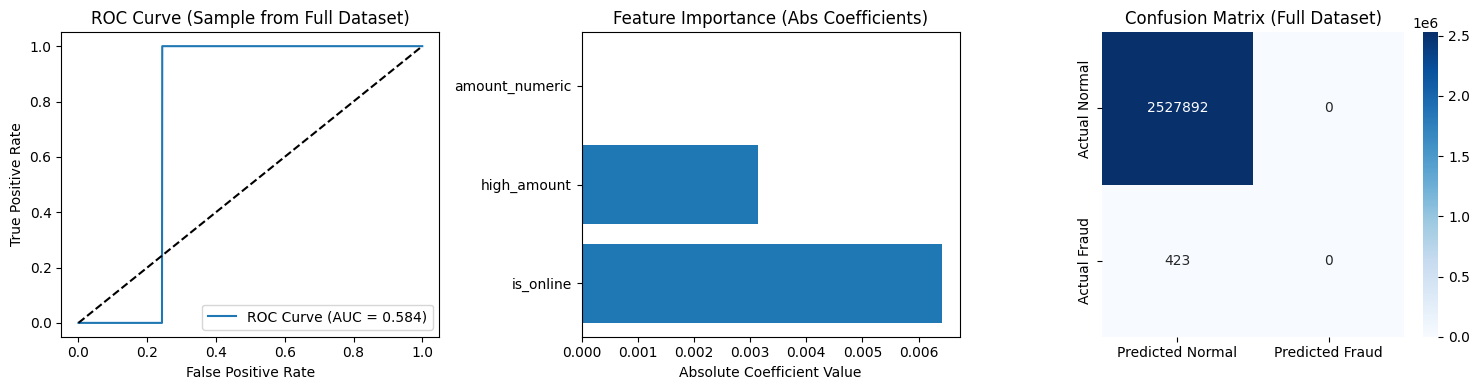

In [ ]:
from sklearn.metrics import roc_curve
import seaborn as sns

# Visualization using sample for plotting
sample_fraud = fraud_predictions.sample(0.001, seed=42).toPandas()

plt.figure(figsize=(15, 4))

# ROC curve (using sample)
plt.subplot(1, 3, 1)
# Extract probability of positive class
sample_fraud['prob_fraud'] = sample_fraud['probability'].apply(lambda x: float(x[1]))
fpr, tpr, _ = roc_curve(sample_fraud['is_fraud'], sample_fraud['prob_fraud'])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Sample from Full Dataset)')
plt.legend()

# Feature Importance
plt.subplot(1, 3, 2)
plt.barh(feature_importance_fraud['feature'], feature_importance_fraud['abs_coefficient'])
plt.title('Feature Importance (Abs Coefficients)')
plt.xlabel('Absolute Coefficient Value')

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = np.array([[tn, fp], [fn, tp]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title('Confusion Matrix (Full Dataset)')

plt.tight_layout()
plt.show()

## 3. Basic Time Series Analysis

Simple time-based patterns in transaction data:

In [ ]:
# Create time-based features for analysis
print("Creating time-based features...")

df_with_time = fraud_data \
    .withColumn("hour", hour(col("date"))) \
    .withColumn("weekday", date_format(col("date"), "EEEE")) \
    .withColumn("is_weekend", dayofweek(col("date")).isin([1, 7]).cast("int"))

print(f"Data with time features: {df_with_time.count():,} transactions")

# 1. Hourly transaction patterns
print("\n1. Hourly patterns:")
hourly_patterns = df_with_time.groupBy("hour").agg(
    sum("amount_numeric").alias("hourly_volume"),
    count("*").alias("transaction_count"),
    avg("is_fraud").alias("fraud_rate")
).orderBy("hour")

hourly_patterns.show(24)

# 2. Daily patterns (weekday analysis)
print("\n2. Weekday patterns:")
weekday_patterns = df_with_time.groupBy("weekday").agg(
    avg("amount_numeric").alias("avg_amount"),
    count("*").alias("transaction_count"),
    avg("is_fraud").alias("fraud_rate")
).orderBy("weekday")

weekday_patterns.show()

# 3. Weekend vs Weekday comparison
print("\n3. Weekend vs Weekday:")
weekend_comparison = df_with_time.groupBy("is_weekend").agg(
    avg("amount_numeric").alias("avg_amount"),
    count("*").alias("transaction_count"),
    avg("is_fraud").alias("fraud_rate")
)

weekend_comparison.show()

Creating time-based features...


Data with time features: 12,635,227 transactions

1. Hourly patterns:


+----+--------------------+-----------------+--------------------+
|hour|       hourly_volume|transaction_count|          fraud_rate|
+----+--------------------+-----------------+--------------------+
|   0|   7848146.799999996|           133365| 0.05004311476024444|
|   1|   7325021.480000002|           111847| 0.04998792994000733|
|   2|          6202669.05|           109290| 0.05040717357489249|
|   3|   6344776.119999993|           101230| 0.05056801343475254|
|   4|  7100932.6399999885|           111650| 0.05071204657411554|
|   5|   9316033.960000005|           176836|0.049989821077156237|
|   6|2.8936822850000005E7|           723353| 0.05033365452275722|
|   7| 3.438895111999999E7|           846234| 0.04996017649964431|
|   8| 3.432421189999987E7|           841920|0.050052261497529456|
|   9|3.3125406019999936E7|           837304| 0.04956025529556768|
|  10| 3.692537430000002E7|           836738| 0.05005389978703011|
|  11| 4.189472044000011E7|           909423| 0.05003502220638

+---------+------------------+-----------------+--------------------+
|  weekday|        avg_amount|transaction_count|          fraud_rate|
+---------+------------------+-----------------+--------------------+
|   Friday| 50.51912001936527|          1801176|0.049855205710047215|
|   Monday|50.960558256270836|          1799729|  0.0499508537118644|
| Saturday| 50.83441385654528|          1805616| 0.05017512029135763|
|   Sunday| 50.62313472342374|          1804727| 0.05012614096204024|
| Thursday| 50.27876833874669|          1821962|0.049833092018384574|
|  Tuesday| 50.51613799476981|          1802706|  0.0499121875669133|
|Wednesday| 50.47789075929633|          1799311| 0.04989743296183928|
+---------+------------------+-----------------+--------------------+


3. Weekend vs Weekday:


+----------+------------------+-----------------+------------------+
|is_weekend|        avg_amount|transaction_count|        fraud_rate|
+----------+------------------+-----------------+------------------+
|         1|50.728800302353754|          3610343|0.0501506366569603|
|         0| 50.54981266795212|          9024884|0.0498896163097498|
+----------+------------------+-----------------+------------------+




4. Creating visualizations...


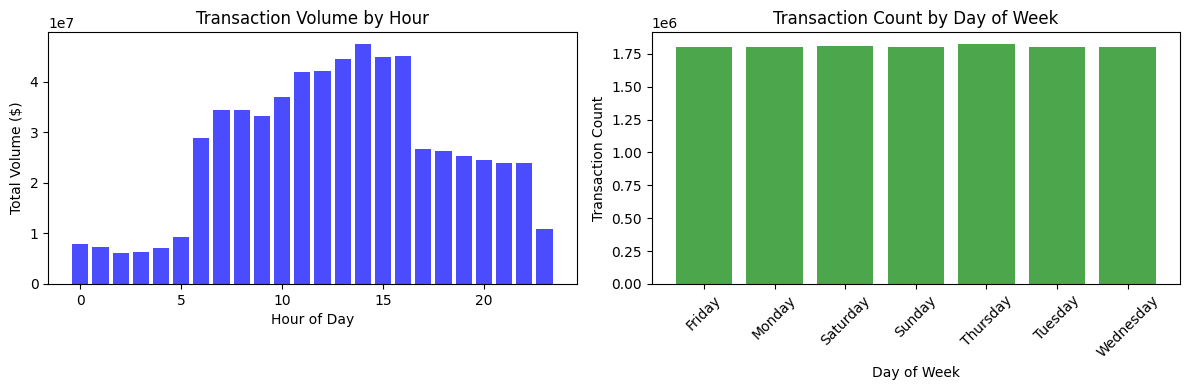

Time series analysis completed!


In [ ]:
# Simple time series visualization
print("\n4. Creating visualizations...")

# Convert to pandas for plotting (using small samples)
hourly_pd = hourly_patterns.toPandas()
weekday_pd = weekday_patterns.toPandas()

plt.figure(figsize=(12, 4))

# Hourly transaction volume
plt.subplot(1, 2, 1)
plt.bar(hourly_pd['hour'], hourly_pd['hourly_volume'], color='blue', alpha=0.7)
plt.title('Transaction Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Volume ($)')

# Weekday transaction patterns
plt.subplot(1, 2, 2)
plt.bar(range(len(weekday_pd)), weekday_pd['transaction_count'], color='green', alpha=0.7)
plt.title('Transaction Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Transaction Count')
plt.xticks(range(len(weekday_pd)), weekday_pd['weekday'], rotation=45)

plt.tight_layout()
plt.show()

print("Time series analysis completed!")

## Summary

This notebook demonstrated essential PySpark concepts:

1. **Data Processing**: Loading and cleaning transaction data
2. **Feature Engineering**: Creating customer features and fraud indicators  
3. **Machine Learning**: Linear and logistic regression with pipelines
4. **Time Series Analysis**: Hourly and daily transaction patterns
5. **Customer Analytics**: Simple segmentation and business insights

### Key PySpark Skills:
- DataFrame operations and transformations
- ML pipelines with VectorAssembler
- Model training and evaluation
- Aggregations and groupBy operations
- Basic visualization with matplotlib

You've successfully learned the fundamentals of distributed machine learning and analytics with PySpark!

### Next Steps:
- Try different ML algorithms (Random Forest, SVM)
- Experiment with feature engineering
- Explore real-time streaming with Structured Streaming
- Learn advanced Spark optimizations

🎉 **Congratulations on completing your PySpark ML journey!**

In [ ]:
# Clean up Spark session
print("Cleaning up Spark resources...")
spark.stop()
print("✅ Spark session terminated successfully!")
print("\n🎊 Workshop completed! You're now ready for production big data analytics!")

Cleaning up Spark resources...


NameError: name 'spark' is not defined